In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
image = cv2.imread('pair_boot.jpg')
template = cv2.imread('boot.jpg')

Số đôi boot tìm được: 6


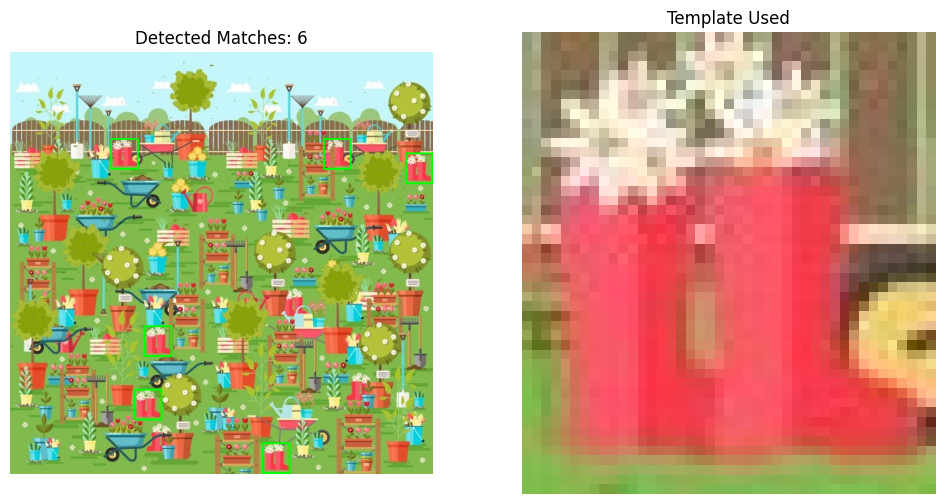

True

In [11]:
## sử dụng những bước xử lý ảnh cơ bản ban đầu, template là ảnh được cắt ra từ 1 đôi boot bất kỳ

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

h, w = template_gray.shape

result = cv2.matchTemplate(image_gray, template_gray, cv2.TM_CCOEFF_NORMED)

threshold = 0.7
locations = np.where(result >= threshold)

rectangles = []
for pt in zip(*locations[::-1]): 
    rectangles.append([pt[0], pt[1], w, h])

rectangles, _ = cv2.groupRectangles(np.array(rectangles).tolist(), groupThreshold=1, eps=0.5)

image_with_boxes = image.copy()
for (x, y, w, h) in rectangles:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

num_matches = len(rectangles)
print(f"Số đôi boot tìm được: {num_matches}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Matches: {num_matches}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template Used")
plt.axis('off')

plt.show()

cv2.imwrite('result_1.jpg', image_with_boxes)

In [12]:
#tính IoU giữa 2 bounding box
def compute_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = w1 * h1
    box2_area = w2 * h2

    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    return inter_area / union_area

In [13]:
#hợp nhất bounding box trùng dùng IoU
def merge_boxes(boxes, iou_threshold=0.1):
    merged_boxes = []
    for box in boxes:
        should_merge = False
        for mbox in merged_boxes:
            if compute_iou(box, mbox) > iou_threshold:
                should_merge = True
                break
        if not should_merge:
            merged_boxes.append(box)
    return merged_boxes

In [14]:
## template matching trên từng template
def process_template(template, image, scale_factor=1):
    
    new_width = int(template.shape[1] * scale_factor)
    new_height = int(template.shape[0] * scale_factor)
    template = cv2.resize(template, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(template_gray, 240, 255, cv2.THRESH_BINARY_INV)
    mask_rgb = cv2.merge([mask, mask, mask])  

    template_h, template_w = template.shape[:2]

    image_r, image_g, image_b = cv2.split(image)
    template_r, template_g, template_b = cv2.split(template)
    mask_r, mask_g, mask_b = cv2.split(mask_rgb)

    result_r = cv2.matchTemplate(image_r, template_r, cv2.TM_SQDIFF_NORMED, mask=mask_r)
    result_g = cv2.matchTemplate(image_g, template_g, cv2.TM_SQDIFF_NORMED, mask=mask_g)
    result_b = cv2.matchTemplate(image_b, template_b, cv2.TM_SQDIFF_NORMED, mask=mask_b)

    result = (result_r + result_g + result_b) / 3

    threshold = 0.095
    locations = np.where(result <= threshold)

    boxes = []
    for pt in zip(*locations[::-1]):
        boxes.append((pt[0], pt[1], template_w, template_h))
    return boxes

Template matching với template có 364 box tìm được.
Số bounding box sau khi gộp: 8
Số đôi boot tìm được: 8


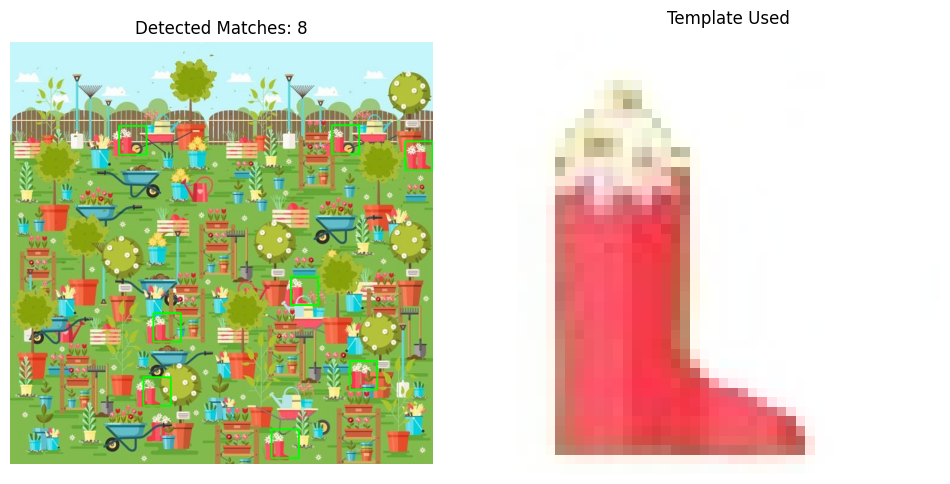

In [17]:
## thay đổi template khác phù hợp hơn là template cũ chỉ cắt ảnh ra
template = cv2.imread('1_boot.jpg')

## thực hiện counting lại dựa trên những hàm đã bổ sung nâng cấp
all_boxes = []
for tmpl in [template]:
    boxes = process_template(tmpl, image, scale_factor=1)
    print(f"Template matching với template có {len(boxes)} box tìm được.")
    all_boxes.extend(boxes)

iou_threshold = 0.1
merged_boxes = merge_boxes(all_boxes, iou_threshold=iou_threshold)
print(f"Số bounding box sau khi gộp: {len(merged_boxes)}")

image_copy = image.copy()
for box in merged_boxes:
    top_left = (box[0], box[1])
    bottom_right = (box[0] + box[2], box[1] + box[3])
    cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

cv2.imwrite('result_2.jpg', image_copy)

num_matches = len(merged_boxes)
print(f"Số đôi boot tìm được: {num_matches}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Matches: {num_matches}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template Used")
plt.axis('off')

plt.show()

Template matching với template có 364 box tìm được.
Template matching với template có 71 box tìm được.
Số bounding box sau khi gộp: 9
Số đôi boot tìm được: 9


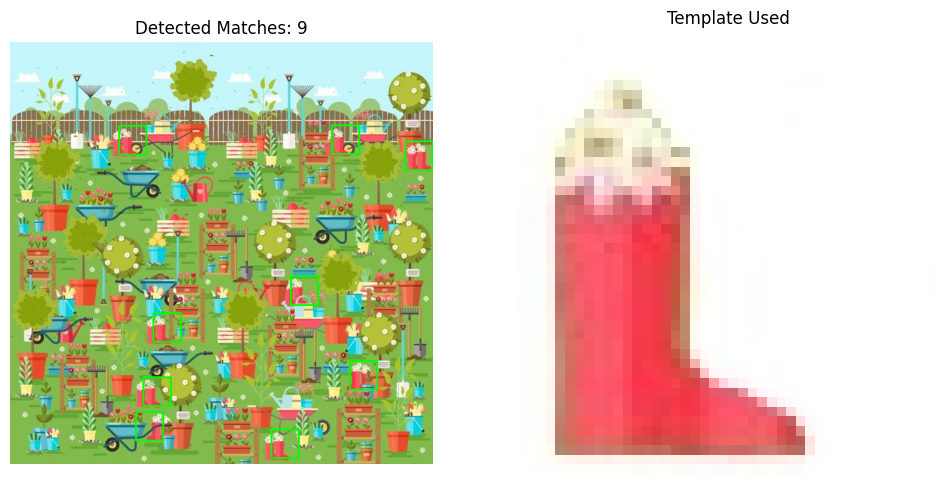

In [18]:
# bổ sung thêm 1 template lật 
template2 = cv2.imread('2_boot.jpg')

all_boxes = []
for tmpl in [template, template2]:
    boxes = process_template(tmpl, image, scale_factor=1)
    print(f"Template matching với template có {len(boxes)} box tìm được.")
    all_boxes.extend(boxes)

merged_boxes = merge_boxes(all_boxes, iou_threshold=0.1)
print(f"Số bounding box sau khi gộp: {len(merged_boxes)}")

image_copy = image.copy()
for box in merged_boxes:
    top_left = (box[0], box[1])
    bottom_right = (box[0] + box[2], box[1] + box[3])
    cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)
    
cv2.imwrite('result_final.jpg', image_copy)

num_matches = len(merged_boxes)
print(f"Số đôi boot tìm được: {num_matches}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Matches: {num_matches}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template Used")
plt.axis('off')

plt.show()